# Variational Autoencoder

A variational autoencoder (VAE) is a kind of **generative** deep learning model that is capable of **unsupervised learning**. Unsupervised learning is the process of fitting models to unlabeled data. A generative model is a specific kind of unsupervised learning model that is capable of *generating* new data points that were not seen in training. Generative models can be viewed as a trained probability distribution over that data: $\hat{\textrm{P}}(x)$. You can then draw samples from this distribution. It is generally too difficult to construct $\hat{\textrm{P}}(x)$ directly, and so most generative models make some changes to the structure. 

A VAE approaches this problem by introducing a dummy random variable $z$, which we define to have a normal distribution. We can then rewrite $\hat{\textrm{P}}(x)$ as:

\begin{equation}
\hat{\textrm{P}}(x) = \int\,\hat{\textrm{P}}\left(x | z \right) \textrm{P}(z)\,dz
\end{equation}

using the definition of a marginal and conditional probability. Training $\hat{\textrm{P}}\left(x | z \right)$ directly is not really possible either, but we can create a symmetric distribution $\hat{\textrm{P}}\left(z | x \right)$ and train both simultaneously. This symmetric distribution only is created to help us train; our end goal is to find $\hat{\textrm{P}}\left(x | z \right)$ so that we can obtain $\hat{\textrm{P}}(x)$. 


A VAE is thus a set of two trained conditional probability distributions that operate on the data $x$ and latent variables $z$. The first conditional is $p_\theta(x | z)$, where $\theta$ indicates the trainable parameters that we will be fitting. $p_\theta(x | z)$ is known as the "decoder" because it goes from the latent variable $z$ to $x$. The decoder analogy is because you can view $z$ as a kind of encoded compression of $x$. The other conditional is $q_\phi(z | x)$ and is known as the encoder. We should also not forget that we chose $p(z)$ to have normal distribution.

## VAE Loss function

To see how $q_\phi(z | x)$ enables us to train, let's construct our loss. The loss function should only take in a value $x_i$ and trainable parameters. There are no labels. Our goal is to make our VAE model be able to generate $x_i$, so the loss is the log likelihood that we saw $x_i$: $\log\left[\hat{\textrm{P}}(x_i)\right]$.


```{margin}
Log likelihood is the loss of choice for fitting distributions to data. It is a likelihood, not a probability, because the distribution parameters are changing, not the random variables (which are set to be the data). We take a log so that we can sum/average over data to aggregate multiple points due to properties of logs. 
```


### Derivation

```{note}
The derivation below is a little unusual. Most derivations rely on Bayes' theorem following a principle of evidence lower bound (ELBO). I thought I'd give a different derivation since you can readily find examples of [the ELBO in many places](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf).
```


Remember we do not have an expression for $\hat{\textrm{P}}(x_i)$. We have $p_\theta(x_i | z)$. To connect them we'll use the following expression:



\begin{equation}
\log\left[\hat{\textrm{P}}(x_i)\right]= \log\left[\int\,p_\theta(x_i | z) \textrm{P}(z)\,dz\right] = \log \textrm{E}_z\left[p_\theta(x_i | z)\right]
\end{equation}

where we have rewritten the integral more compactly by using the definition of expectation. This expression requires integrating over the latent variable, which is not easy since as you can guess $p_\theta(x | z)$ is a neural network and it's not straightforward to integrate over the input ($z$) of a neural network. Instead, we can approximate this integral by sampling some $z$s from $P(z)$

```{margin}
We actually could just integrate over the latent variables. This is called a normalizing flow and is a class of generative models we'll see later. 
```

\begin{equation}
 \log\textrm{E}_z\left[ p_\theta(x_i | z)\right]\approx \log \left[\frac{1}{N}\sum_j^N  p_\theta(x_i | z_j)\right],\, z_j \sim P(z_j)
\end{equation}

You'll find though that grabbing $z$'s from $P(z)$ is not so efficient at approximating this integral, because you need the $z$'s to be likely to have led to the observed $x_i$. The integral is dominated by the $p_\theta(x_i | z_j)$ terms. This is where we use $q(z | x)$: it can provide efficient guesses for $z_j$. To approximate $\log \textrm{E}_z\left[p_\theta(x_i | z)\right]$ with samples from $q(z | x_i)$, we need to account for the fact that sampling from $q(z | x_i)$ is not identical to sampling from $P(z)$ by adding their ratio to the expression ([importance sampling](https://en.wikipedia.org/wiki/Importance_sampling)).


\begin{equation}
 \log\textrm{E}_z\left[ p_\theta(x_i | z)\right]\approx \log \left[\frac{1}{N}\sum^N_j  p_\theta(x_i | z_j) \frac{P(z_j)}{q_\phi(z_j | x_i)}\right],\, z_j \sim q_\phi(z_j | x_i)
\end{equation}

The ratio of $P(z) / q_\phi(z | x)$ enables our numerical approximation of the expectation. For notational purposes though I'll go back to the exact expression, with the understanding that when we go to implementation we'll use the numerical approximation:

\begin{equation}
 \log\textrm{E}_z\left[ p_\theta(x_i | z)\right] = \log\textrm{E}_{z \sim q_\phi(z | x_i)}\left[ p_\theta(x_i | z) \frac{P(z)}{q_\phi(z | x_i)}\right]
\end{equation}

Notice how the expectation now is wrt $z \sim q_\phi(z | x_i)$ since we have that importance sampling ratio in the expression.

Now if the log was on the inside of our expectation, we could simplify this. We can actually swap the order of expectation and the log using Jensen's Inequality for the concave log function. The consequence is that our loss is no longer an exact estimate of the log likelihood, but a lower bound. 

\begin{equation}
\log \textrm{E}\left[\ldots\right]\geq \textrm{E}\left[\log \ldots\right]
\end{equation}

We'll use that and can now separate into two terms by properties of the log

\begin{equation}
\textrm{E}_{z \sim q_\phi(z | x_i)}\left[ \log\left(p_\theta(x_i | z) \frac{P(z)}{q_\phi(z | x_i)}\right)\right] = \textrm{E}_{z \sim q_\phi(z | x_i)}\left[ \log p_\theta(x_i | z)\right] + \textrm{E}_{z \sim q_\phi(z | x_i)}\left[ \log \left(\frac{P(z)}{q_\phi(z | x_i)}\right)\right]
\end{equation}

Remember we always planned to re-introduce numerically approximate the expectation. However, the right-hand side does not involve $p_\theta(x | z)$, so we do not need to integrate over a neural network input. We just need to integrate over the output of $q_\phi(z | x)$ and $P(z)$, which is a standard normal distribution. We'll see later on that we can make the output of $q_\phi(z | x)$ specifically be a normal distribution to make sure we can easily compute the integral. Finally, we can use an identity that relates the Kullback–Leibler divergence (KL divergence) (a binary functional of two probabilities) to the right-hand side term:

\begin{equation}
\textrm{E}_{p(x)}\left[ \ln\left(\frac{q(x)}{p(x)}\right)\right] = -\textrm{KL}\left[p(x)|| q(x)\right]
\end{equation}

arriving at our final result:

### Log-Likelihood Approximation

\begin{equation}
\log\left[\hat{\textrm{P}}(x_i)\right] \geq \textrm{E}_{z \sim q_\phi(z | x_i)}\left[ \log p_\theta(x_i | z)\right] -\textrm{KL}\left[q_\phi(z | x_i)|| P(z)\right]
\end{equation}

The left term is called the **reconstruction loss** and assess how close we come after going from $x \rightarrow z \rightarrow x$ in expectation. The right-hand term is the **KL-divergence** and measures how close our encoder is to our defined $P(z)$ (normal distribution). The right-hand term involves an integral that can be computed analytically and no sampling is required to estimate it. Remember, in the derivation the KL-divergence term appeared as a correction term to account for the fact that our loss doesn't use $P(z)$ directly, but instead uses the encoder $q_\phi(z | x_i)$ which generates $z$'s from our training data point $x_i$. The last step is that we want to minimize our loss, so we need to add a minus sign.

```{note}
The log-likelihood equation we've derived for VAE training is also sometimes called the evidence lower bound (ELBO). ELBO is a general equation used in Bayesian modeling, which usually has nothing to do with VAEs. 
```

\begin{equation}
\mathcal{L}(x_i, \phi, \theta) =  -\textrm{E}_{z \sim q_\phi(z | x_i)}\left[ \log p_\theta(x_i | z)\right] +\textrm{KL}\left[q_\phi(z | x_i)|| P(z)\right]
\end{equation}

Remember that in practice, we will approximate the expectation in the reconstruction loss by sampling $z$'s from the decoder $q_\phi(z | x)$. We'll only use a single sample.



## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy pandas seaborn jax jaxlib
```

````

## VAE Classifier

Our first example will be multi-class classification. Our features $x$ are one-hot vectors indicating class and our goal is to learn the distribution $P(x)$ so that we can sample new $x$'s. Learning the latent space can also provide a way to embed your features into low dimensional continuous space, allowing you to do things like optimization. That is an extra benefit, our loss and training goal are to create a new $P(x)$.

Let's think for a moment about our encoder and decoder. $q_\phi(z | x)$, the encoder, should give out a *probability distribution* for vectors of real numbers $z$ and take an input of a one-hot vector $x$. This sounds difficult; we've never seen a neural network output a probability distribution over real number vectors. We can simplify though. We defined $P(z)$ to be normally distributed, let's assume that the form of $q_\phi(z | x)$ should be normal. Then our neural network could output the parameters to a normal distribution (mean/variance) for $z$, rather than trying to output a probability at every possible $z$ value. It's up to you if you want to have $q_\phi(z | x)$ output a D-dimensional Gaussian distribution with a covariance matrix or just output D independent normal distributions. Having $q_\phi(z | x)$ output a normal distribution also allows us to analytically simplify the expectation/integral in the KL-divergence term. 

The decoder $p_\theta(x | z)$ should output a probability distribution over classes given a real vector $z$. We can use the same form we used for classification: softmax activation. Just remember that we're not trying to output a specific $x$, just a probability distribution of $x$'s. 

Choices we have to make are the hyperparameters of the encoder and decoder and the size of $z$. It makes sense to have the encoder and decoder share as many hyperparameters as possible, since they're somewhat symmetric. Just remember that the encoder in our example is outputting a mean and variance, which means using regression, and the decoder is outputting a normalized probability vector, which means using softmax. Let's get started!

### The Data
The data is 1024 points $\vec{x}_i$ where each $\vec{x}_i$ is a 32 dimensional one-hot vector indicating class. We won't define the classes -- the data is synthetic. Since a VAE is unsupervised learning, there are no labels. Let's start by examining the data. We'll sum the occurrences of each class to see what the distribution of classes looks like. *The hidden cells show how the data was generated*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

In [2]:
sampled_z = np.random.choice([0,1], size=1024)
data = ((sampled_z + 1) % 2) * np.random.normal(size=sampled_z.shape, loc=-1, scale=0.5) + \
    sampled_z * np.random.normal(size=sampled_z.shape, loc=1, scale=0.25)
nbins = 32
_, bins = np.histogram(data, bins=nbins)
class_data = np.apply_along_axis(lambda x: np.histogram(x, bins)[0], 1, data.reshape(-1, 1))
nclasses = nbins

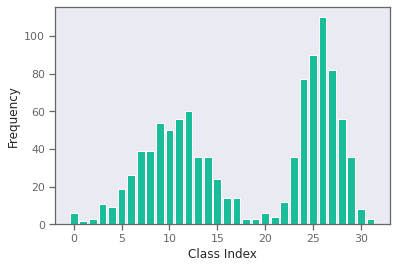

In [3]:
plt.bar(np.arange(nclasses), height=np.sum(class_data, axis=0))
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.show()

### The encoder

Our encoder will be a basic two hidden layer network. We will output a $D\times2$ matrix, where the first column is means and the second is standard deviations for independent normal distributions that make up our guess for $q(z | x)$. Outputting a mean is simple, just use no activation. Outputting a standard deviation is unusual because they should be on $(0, \infty)$. Softplus can accomplish this. 

In [4]:
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import jax
import functools

def random_vec(size):
    return np.random.normal(size=size, scale=1)

In [5]:
latent_dim = 1
hidden_dim = 16
input_dim = nclasses

def encoder(x, theta):
    '''The encoder takes as input x and gives out probability of z,
       expressed as normal distribution parameters. Assuming each z dim is independent,
       output |z| x 2 matrix'''
    w1, w2, w3, b1, b2, b3 = theta
    hx = jax.nn.relu(w1 @ x + b1)
    hx = jax.nn.relu(w2 @ hx + b2)
    out = w3 @ hx + b3
    # slice out stddeviation and make it positive
    reshaped = out.reshape((-1, 2))
    # we slice with ':' to keep rank same
    std = jax.nn.softplus(reshaped[:,1:])
    mu = reshaped[:,0:1]    
    return jnp.concatenate((mu, std), axis=1)
    
def init_theta(input_dim, hidden_units, latent_dim):
    '''Create inital theta parameters'''
    w1 = random_vec(size=(hidden_units, input_dim))
    b1 = np.zeros(hidden_units)
    w2 = random_vec(size=(hidden_units, hidden_units))
    b2 = np.zeros(hidden_units)
    # need to params per dim (mean, std)
    w3 = random_vec(size=(latent_dim * 2, hidden_units))
    b3 = np.zeros(latent_dim * 2)
    return [w1, w2, w3, b1, b2, b3]

# test them
theta = init_theta(input_dim, hidden_dim, latent_dim)
encoder(class_data[0], theta)

DeviceArray([[0.67200387, 0.00897247]], dtype=float32)

The decoder should output a vector of probabilities for $\vec{x}$. This can be achieved by just adding a softmax to the output. The rest is nearly identical to the encoder. 

In [6]:
def decoder(z, phi):
    '''decoder takes as input the latant variable z and gives out probability of x.
    Decoder outputes a real number, then we use softmax activation to get probability across
    possible values of x. 
     '''
    w1, w2, w3, b1, b2, b3 = phi
    hz = jax.nn.relu(w1 @ z + b1)
    hz = jax.nn.relu(w2 @ hz + b2)
    out = jax.nn.softmax(w3 @ hz + b3)   
    return out

def init_phi(input_dim, hidden_units, latent_dim):
    '''Create inital phi parameters'''
    w1 = random_vec(size=(hidden_units, latent_dim))
    b1 = np.zeros(hidden_units)
    w2 = random_vec(size=(hidden_units, hidden_units))
    b2 = np.zeros(hidden_units)
    w3 = random_vec(size=(input_dim, hidden_units))
    b3 = np.zeros(input_dim)
    return [w1, w2, w3, b1, b2, b3]
# test it out
phi = init_phi(input_dim, hidden_dim, latent_dim)
decoder(np.array([1.2] * latent_dim), phi)

DeviceArray([1.4369683e-11, 2.8801292e-29, 3.2273541e-20, 7.1850895e-22,
             1.0793007e-22, 2.8247908e-20, 8.5903684e-09, 5.0419994e-28,
             3.8993281e-25, 1.9217204e-23, 1.3062071e-12, 2.6221546e-16,
             4.2119552e-23, 1.1967079e-20, 4.3358453e-27, 3.8699083e-20,
             1.3168897e-22, 3.3939088e-20, 5.1175348e-27, 3.9091000e-24,
             1.0000000e+00, 1.6622006e-19, 2.5878642e-29, 3.6575650e-17,
             5.0655268e-25, 3.9531148e-23, 5.9112239e-20, 3.3607102e-19,
             6.1983621e-12, 2.7988031e-19, 9.9489904e-13, 3.6622517e-27],            dtype=float32)

## Training

We use ELBO equation for training:

$$
l = -\textrm{E}_{z \sim q_\phi(z | x_i)}\left[\log p_{\theta}(x_i | z)\right] + \textrm{KL}\left[(q_\phi(z | x))|| P(z)\right]
$$

where $P(z)$ is the standard normal distribution and we approximate expectations using a single sample from the encoder. We need to expand the KL-divergence term to implement. Both $P(z)$ and $q_\theta(z | x)$ are normal. You can look-up the KL-divergence between two normal distributions:

\begin{equation}
KL(q, p) = \log \frac{\sigma_p}{\sigma_q} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{2 \sigma_p^2} - \frac{1}{2}
\end{equation}

we can simplify because $P(z)$ is standard normal ($\sigma = 1, \mu = 0$)

\begin{equation}
\textrm{KL}\left[(q_\theta(z | x_i))|| P(z)\right] = -\log \sigma_i + \frac{\sigma_i^2}{2} + \frac{\mu_i^2}{2} - \frac{1}{2}
\end{equation}

where $\mu_i, \sigma_i$ are the output from $q_\phi(z | x_i)$

In [7]:
@jax.jit
def loss(x, theta, phi, rng_key):
    '''VAE Loss'''
    # reconstruction loss
    sampled_z_params = encoder(x, theta)
    # reparameterization trick
    # we use standard normal sample and multiply by parameters
    # to ensure derivatives correctly propogate to encoder
    sampled_z = jax.random.normal(rng_key, shape=(latent_dim,)) * sampled_z_params[:, 1] + sampled_z_params[:, 0]
    # log of prob
    rloss = -jnp.log(decoder(sampled_z, phi) @ x.T + 1e-8)
    # LK loss
    klloss = -0.5 - jnp.log(sampled_z_params[:, 1]) + 0.5 * sampled_z_params[:,0]**2 + 0.5 * sampled_z_params[:,1]**2    
    # combined    
    return jnp.array([rloss, jnp.mean(klloss)])
# test it out
loss(class_data[0], theta, phi, jax.random.PRNGKey(0))

DeviceArray([18.420681,  4.439429], dtype=float32)

Our loss works! Now we need to make it batched so we can train in batches. Luckily this is easy with jax.

In [8]:
batched_loss = jax.vmap(loss, in_axes=(0, None, None, None), out_axes=0)
batched_decoder = jax.vmap(decoder, in_axes=(0,None), out_axes=0)
batched_encoder = jax.vmap(encoder, in_axes=(0,None), out_axes=0)

# test batched loss
batched_loss(class_data[:4], theta, phi, jax.random.PRNGKey(0))

DeviceArray([[18.420681  ,  4.439429  ],
             [18.420681  , 32.165703  ],
             [ 0.17430553, 73.976494  ],
             [18.420681  ,  4.439429  ]], dtype=float32)

We'll make our gradient take the average over the batch

In [9]:
grad = jax.grad(lambda x, theta, phi, rng_key: jnp.mean(batched_loss(x, theta, phi, rng_key)), (1, 2))
fast_grad = jax.jit(grad)
fast_loss = jax.jit(batched_loss)

Alright, great! An important detail we've skipped so far is that when using `jax` to generate random numbers, we must step our random number generator forward. You can do that using `jax.random.split`. Otherwise, you'll get the same random numbers at each draw.

We're going to use a `jax` optimizer here. This is to simplify parameter updates. We have a lot of parameters and they are nested, which will be complex for treating with python for loops.

In [10]:
batch_size = 32
epochs = 16

key = jax.random.PRNGKey(0)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)    
theta0 = init_theta(input_dim, hidden_dim, latent_dim)
phi0 = init_phi(input_dim, hidden_dim, latent_dim)
opt_state = opt_init((theta0, phi0))
losses = []
for e in range(epochs):
    for bi,i in enumerate(range(0, len(data), batch_size)):
        # make a batch into shape B x 1
        batch = class_data[i:(i + batch_size)]
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key)    
        opt_state = opt_update(bi, grad, opt_state)
        lvalue = jnp.mean(fast_loss(batch, theta, phi, subkey), axis=0)
        losses.append(lvalue)

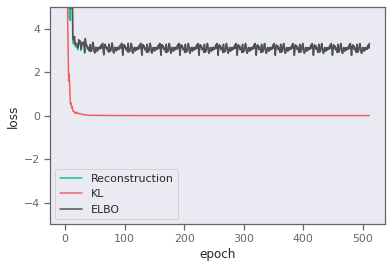

In [11]:
plt.plot([l[0] for l in losses], label='Reconstruction')
plt.plot([l[1] for l in losses], label='KL')
plt.plot([l[1] + l[0] for l in losses], label='ELBO')
plt.legend()
plt.ylim(-5, 5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Evaluating the VAE

Remember our goal with the VAE is to reproduce $P(x)$. We can sample from our VAE using the chosen $P(z)$ and our decoder. Let's compare that distribution with our training distribution.

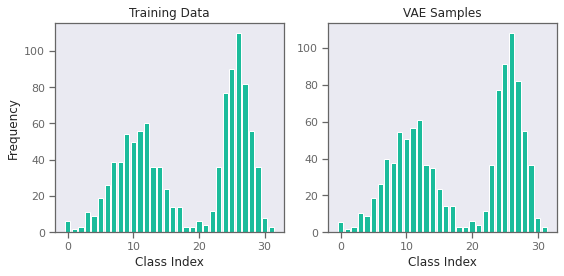

In [12]:
zs = np.random.normal(size=(1024, 1))
sampled_x = batched_decoder(zs, phi)
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].set_title('Training Data')
axs[0].bar(np.arange(nbins), height=np.sum(class_data, axis=0))
axs[0].set_xlabel('Class Index')
axs[0].set_ylabel('Frequency')
axs[1].set_title('VAE Samples')
axs[1].bar(np.arange(nbins), height=np.sum(sampled_x, axis=0))
axs[1].set_xlabel('Class Index')
plt.tight_layout()
plt.show()

It appears we have succeeded! There two more goals of the VAE which were trained: making the encoder give output similar to $P(z)$ and be able to reconstruct. These goals are often opposed and they represent the two terms in the loss: reconstruction and KL-divergence. Let's examine the KL-divergence term, which causes the encoder to give output similar to a standard normal. We'll sample from our training data in histogram look at the resulting average mean and std dev. 

In [13]:
d = batched_encoder(class_data, theta)
print('Average mu = ', np.mean(d[...,0]), 'Average std dev = ', np.mean(d[...,1]))

Average mu =  0.00038815482 Average std dev =  0.9998034


Wow! Very close to a standard normal. So our model satisfied the match between the decoder and the $P(z)$. The last thing to check is reconstruction. These are distributions, so I'll only look at the maximum $z$ value to do the reconstruction.

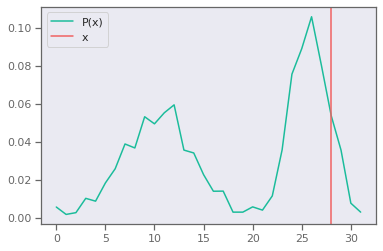

In [14]:
plt.plot(decoder(encoder(class_data[2], theta)[0:1,0], phi), label='P(x)')
plt.axvline(np.argmax(class_data[2]), color='C1', label='x')
plt.legend()
plt.show()

The reconstruction is not great, it puts a lot of probability mass on other points. In fact, the reconstruction seems to not use the encoder's information at all -- it looks like $P(x)$. The reason for this is that our KL-divergence term dominates. It has a very good fit.

## Re-balancing VAE Reconstruction and KL-Divergence

Often we desire more reconstruction at the cost of making the latent space less normal. This can be done by adding a term that adjusts the balance between the reconstruction loss and the KL-divergence. You would choose to do this if you want to use the latent space for something and are not just interested in creating a model $\hat{P}(x)$. Let's see an example. 

In [15]:
def modified_loss(x, theta, phi, rng_key, beta):
    '''This loss allows you to vary which term is more important 
    with beta. Beta = 0 - all reconstruction, beta = 1 - ELBO'''
    bl = batched_loss(x, theta, phi, rng_key)
    l = bl @ jnp.array([1., beta])
    return jnp.mean(l)

new_grad = jax.grad(modified_loss, (1, 2))
fast_grad = jax.jit(new_grad)

In [16]:
# note we used a lower step size for this loss
# and more epochs
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-2)    
epochs = 32
theta0 = init_theta(input_dim, hidden_dim, latent_dim)
phi0 = init_phi(input_dim, hidden_dim, latent_dim)
opt_state = opt_init((theta0, phi0))
beta = 0.2
losses = []
for e in range(epochs):
    for bi,i in enumerate(range(0, len(data), batch_size)):
        # make a batch into shape B x 1
        batch = class_data[i:(i + batch_size)]
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key, beta)    
        opt_state = opt_update(bi, grad, opt_state)
        lvalue = jnp.mean(fast_loss(batch, theta, phi, subkey), axis=0)
        losses.append(lvalue)

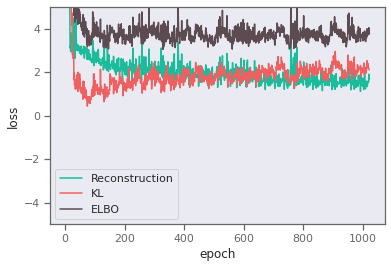

In [17]:
plt.plot([l[0] for l in losses], label='Reconstruction')
plt.plot([l[1] for l in losses], label='KL')
plt.plot([l[1] + l[0] for l in losses], label='ELBO')
plt.legend()
plt.ylim(-5, 5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

You can see the error is higher, but let's see how it did at our three metrics. 

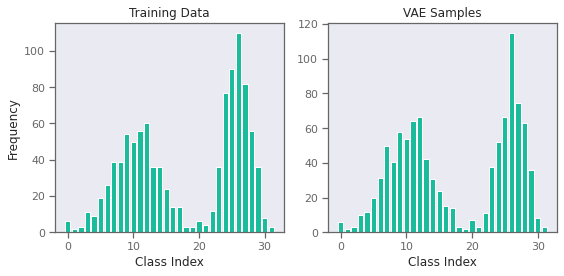

In [18]:
zs = np.random.normal(size=(1024, 1))
sampled_x = batched_decoder(zs, phi)
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].set_title('Training Data')
axs[0].bar(np.arange(nbins), height=np.sum(class_data, axis=0))
axs[0].set_xlabel('Class Index')
axs[0].set_ylabel('Frequency')
axs[1].set_title('VAE Samples')
axs[1].bar(np.arange(nbins), height=np.sum(sampled_x, axis=0))
axs[1].set_xlabel('Class Index')
plt.tight_layout()
plt.show()

A little bit worse on $P(x)$, but overall not bad. What about our goal, the reconstruction?

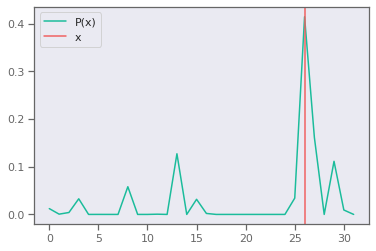

In [19]:
plt.plot(decoder(encoder(class_data[4], theta)[0:1,0], phi), label='P(x)')
plt.axvline(np.argmax(class_data[4]), color='C1', label='x')
plt.legend()
plt.show()

What about our encoder's agreement with a standard normal?

In [20]:
d = batched_encoder(class_data, theta)
print('Average mu = ', np.mean(d[...,0]), 'Average std dev = ', np.mean(d[...,1]))

Average mu =  0.10855511 Average std dev =  0.17541122


The standard deviation is much smaller! So we squeezed our latent space a little at the cost of better reconstruction.

## Regression VAE

We'll now work with continuous features $x$. We need to make a few key changes. The encoder will remain the same, but the decoder now must output a $p_\theta(x | z)$ that gives a probability to all possible $x$ values. Above, we only had a finite number of classes but now any $x$ is possible. As we did for the encoder, we'll assume that $p_\theta(x | z)$ should be normal and we'll output the parameters of the normal distribution from our network. This requires an update to the reconstruction loss to be a log of a normal, but otherwise things will be identical. 

One of the mistakes I always make is that the log-likelihood for a normal distribution with a single observation cannot have unknown standard deviation. Our new normal distribution parameters for the decoder will have a single observation for a single $x$ in training. If you make the standard deviation trainable, it will just pick infinity as the standard deviation since that will for sure capture the point and you only have one point. Thus, I'll make the decoder standard deviation be a hyperparameter fixed at 0.1. We don't see this issue with the encoder, which also outputs a normal distribution, because we training the encoder with the KL-divergence term and not likelihood of observations (reconstruction loss).


In [21]:
latent_dim = 1
hidden_dim = 16
input_dim = 1

# make encoder parameters
theta = init_theta(input_dim, hidden_dim, latent_dim)
# test it
encoder(data[0:1], theta)

DeviceArray([[-0.48632216,  0.6864413 ]], dtype=float32)

In [22]:
def decoder(z, phi):
    '''decoder takes as input the latant variable z and gives out probability of x.
    Decoder outputes parameters for a normal distribution
     '''
    w1, w2, w3, b1, b2, b3 = phi
    hz = jax.nn.relu(w1 @ z + b1)
    hz = jax.nn.relu(w2 @ hz + b2)
    out = w3 @ hz + b3
    # slice out stddeviation and make it positive
    reshaped = out.reshape((-1, 2))
    # we slice with ':' to keep rank same
    #std = jax.nn.softplus(reshaped[:,1:])
    std = jnp.ones_like(reshaped[:,1:]) * 0.1
    mu = reshaped[:,0:1]    
    return jnp.concatenate((mu, std), axis=1)

def init_phi(input_dim, hidden_units, latent_dim):
    '''Create inital phi parameters'''
    w1 = random_vec(size=(hidden_units, latent_dim))
    b1 = np.zeros(hidden_units)
    w2 = random_vec(size=(hidden_units, hidden_units))
    b2 = np.zeros(hidden_units)
    w3 = random_vec(size=(input_dim * 2, hidden_units))
    b3 = np.zeros(input_dim * 2)
    return [w1, w2, w3, b1, b2, b3]
# test it out
phi = init_phi(input_dim, hidden_dim, latent_dim)
decoder(np.array([1.2] * latent_dim), phi)

DeviceArray([[8.568987, 0.1     ]], dtype=float32)

In [23]:
@jax.jit
def loss(x, theta, phi, rng_key):
    '''VAE Loss'''
    # reconstruction loss
    sampled_z_params = encoder(x, theta)
    # reparameterization trick
    # we use standard normal sample and multiply by parameters
    # to ensure derivatives correctly propogate to encoder
    sampled_z = jax.random.normal(rng_key, shape=(latent_dim,)) * sampled_z_params[:, 1] + sampled_z_params[:, 0]
    # log of normal dist
    out_params = decoder(sampled_z, phi)
    rloss = -jnp.log(jnp.sqrt(2 * np.pi) * out_params[:,1] + 1e-10) + (x - out_params[:,0])**2 / out_params[:,1]**2 / 2    
    klloss = -0.5 - jnp.log(sampled_z_params[:, 1]) + 0.5 * sampled_z_params[:,0]**2 + 0.5 * sampled_z_params[:,1]**2    
    # combined    
    return jnp.array([jnp.mean(rloss), jnp.mean(klloss)])
# test it out
loss(data[0:1], theta, phi, jax.random.PRNGKey(0))

# update compiled functions
batched_loss = jax.vmap(loss, in_axes=(0, None, None, None), out_axes=0)
batched_decoder = jax.vmap(decoder, in_axes=(0,None), out_axes=0)
batched_encoder = jax.vmap(encoder, in_axes=(0,None), out_axes=0)
grad = jax.grad(lambda x, theta, phi, rng_key: jnp.mean(batched_loss(x, theta, phi, rng_key)), (1, 2))
fast_grad = jax.jit(grad)
fast_loss = jax.jit(batched_loss)

In [24]:
batch_size = 32
epochs = 64

key = jax.random.PRNGKey(0)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)    
theta0 = init_theta(input_dim, hidden_dim, latent_dim)
phi0 = init_phi(input_dim, hidden_dim, latent_dim)
opt_state = opt_init((theta0, phi0))
losses = []
for e in range(epochs):
    for bi,i in enumerate(range(0, len(data), batch_size)):
        # make a batch into shape B x 1
        batch = data[i:(i + batch_size)].reshape(-1, 1)
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key)    
        opt_state = opt_update(bi, grad, opt_state)
        lvalue = jnp.mean(fast_loss(batch, theta, phi, subkey), axis=0)
        losses.append(lvalue)

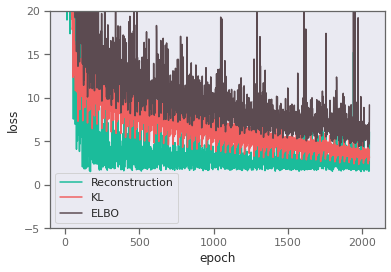

In [25]:
plt.plot([l[0] for l in losses], label='Reconstruction')
plt.plot([l[1] for l in losses], label='KL')
plt.plot([l[1] + l[0] for l in losses], label='ELBO')
plt.legend()
plt.ylim(-5, 20)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

This model still has training to be done, but hopefully you get the idea for working with continuous numbers! We can examine the final result below. Note that I must sample from the output parameters to compare with the real training data.

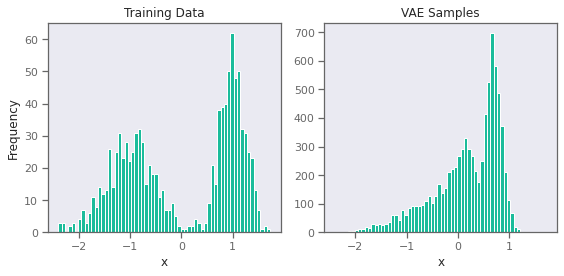

In [26]:
bins = 64
zs = np.random.normal(size=(1024, 1))
sampled_x_params = batched_decoder(zs, phi)
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].set_title('Training Data')
_, bins, _ = axs[0].hist(data, bins=bins)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Frequency')
axs[1].set_title('VAE Samples')
# Now we have to sample from output paramters!!
samples = []
for s in sampled_x_params:
    samples.append(np.random.normal(scale=s[:,1], loc=s[:,0], size=(8)))
samples = np.array(samples).flatten()
# make them use same bins
axs[1].hist(samples, bins=bins)
axs[1].set_xlabel('x')
plt.tight_layout()
plt.show()

The distribution is alright, not great. Comparing reconstruction is a little different because we only compare the mean of the predicted $P(x)$. We'll plot our predicted $\mu$ from the decoder against the real $x$ values.

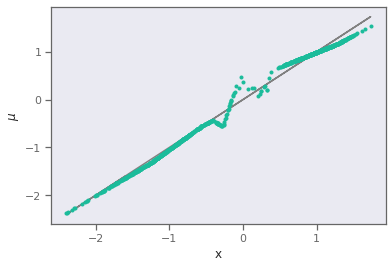

In [27]:
mus = batched_decoder(batched_encoder(data.reshape(-1,1), theta)[:,:,0], phi)[:,0,0]

plt.plot(data, mus, '.')
plt.plot(data, data, '-', zorder=-1, color='gray')
plt.xlabel('x')
plt.ylabel('$\mu$')
plt.show()

The reconstruction is actually quite good! There is some odd behavior near the top, but otherwise quite reasonable. Finally check how well we did with getting our latent space to be standard normal.

In [28]:
d = batched_encoder(data.reshape(-1,1), theta)
print('Average mu = ', np.mean(d[...,0]), 'Average std dev = ', np.mean(d[...,1]))

Average mu =  0.50994813 Average std dev =  0.41120058


Surprisingly poor. This gets at one of the issues with VAEs: sometimes your KL will dominate and you have poor reconstruction and other times reconstruction will dominate. It just depends on the variance of your features, dimensions, and hyperparameters. You'll often want to explicitly balance those terms to better agree with your goals for constructing the VAE.

## Bead-Spring Polymer VAE

Now we'll move on to a more realistic system. We'll use a bead-spring polymer as shown in the short trajectory snippet below.

<div>
    <video width="500" autoplay loop controls src="../_static/images/traj.mp4" alt="movie of point trajectory"></video>
</div>



This polymer has each bead (atom) joined by a harmonic bond, a harmonic angle between each three, and a Lennard-Jones interaction potential. Knowing these items will not be necessary for the example. We'll construct a VAE that can compress the trajectory to some latent space and generate new conformations.

To begin, we'll use the lessons learned from {doc}`data` about how to align points from a trajectory. This will then serve as our training data. The space of our problem will be 12 2D vectors. Our system need not be permutation invariant, so we can flatten these vectors into a 24 dimensional input. The code belows loads and aligns the trajectory

In [29]:
import numpy as np
###---------Transformation Functions----###
def center_com(paths):
    '''Align paths to COM at each frame'''
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms
def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)

def find_principle_axis(points):
    '''Compute single principle axis for points'''
    inertia = points.T @ points
    evals, evecs = np.linalg.eigh(inertia)
    # get biggest eigenvalue
    order = np.argsort(evals)    
    return evecs[:, order[-1]]

def align_principle(paths):
    # someone should tell me how to vectorize this in numpy 
    vecs = [find_principle_axis(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:,1], vecs[:,0])
    rot_angle = -cur_angle
    rot_mat = make_2drot(rot_angle)
    # to mat mult at each frame
    return paths @ rot_mat
###-----------------------------------###

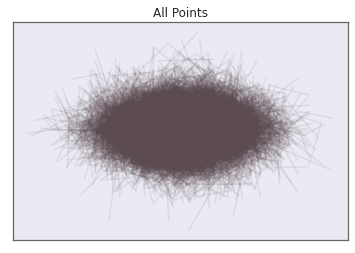

In [30]:
#TODO change to github link
paths = np.load('../data/long_paths.npz')['arr']
# transform to be rot/trans invariant
data = align_principle(center_com(paths))
cmap = plt.get_cmap('cool')
for i in range(0, data.shape[0]):
    plt.plot(data[i, :, 0], data[i, :, 1], '-', alpha=0.1, color='C2')
plt.title('All Points')
plt.xticks([])
plt.yticks([])
plt.show()

Before training, let's examine some of the **marginals** of the data. Marginals mean we've transformed (by integration) our probability distribution to be a function of only 1-2 variables so that we can plot nicely. We'll look at the pairwise distance between points. 

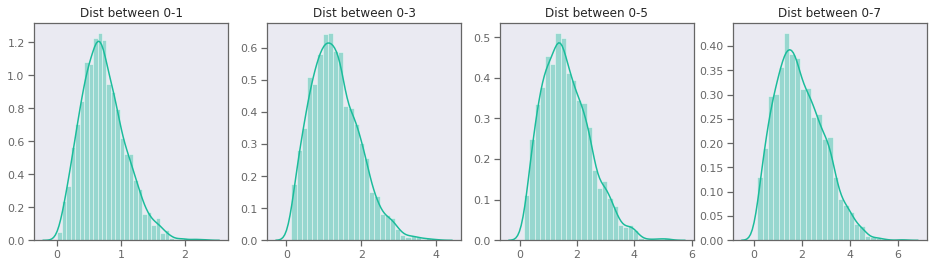

In [31]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i,j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f'Dist between 0-{j}')
    sns.distplot(np.linalg.norm(data[:,0] - data[:,j], axis=1), ax=axs[i])
    

These look a little like the chi distribution with two degrees of freedom. Notice that the support (x-axis) changes between them though. We'll keep an eye on these when we evaluate the efficacy of our VAE. 

### VAE Model

We'll build the VAE like above. I will make two changes. I will use JAX's random number generator and I will make the number of layers variable. The code is hidden below, but you can expand to see the details. We'll be starting with 4 layers total (3 hidden) with a hidden layer dimension of 256. Another detail is that we flatten the input/output since the order is preserved and thus we do not worry about separating the x,y dimension out.

In [32]:
input_dim = 12 * 2
hidden_units = 256
num_layers = 4
latent_dim = 2

def init_theta(input_dim, hidden_units, latent_dim, num_layers, key, scale=0.1):
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(key=subkey, shape=(hidden_units, latent_dim)) * scale
    b1 = jnp.zeros(hidden_units)
    theta = [(w1, b1)]
    for i in range(1, num_layers - 1):
        key, subkey = jax.random.split(key)
        w = jax.random.normal(key=subkey, shape=(hidden_units, hidden_units)) * scale
        b = jnp.zeros(hidden_units)
        theta.append((w, b))
    key, subkey = jax.random.split(key)
    w = jax.random.normal(key=subkey, shape=(input_dim, hidden_units)) * scale
    b = jnp.zeros(input_dim)
    theta.append((w, b))
    return theta, key

def decoder(z, theta):
    num_layers = len(theta)
    for i in range(num_layers - 1):
        w, b = theta[i]
        z = jax.nn.relu(w @ z + b)
    w, b = theta[-1]
    x = w @ z + b
    return x

def init_phi(input_dim, hidden_units, latent_dim, num_layers, key, scale=0.1):
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(key=subkey, shape=(hidden_units, input_dim)) * scale
    b1 = jnp.zeros(hidden_units)
    phi = [(w1, b1)]
    for i in range(1, num_layers - 1):
        key, subkey = jax.random.split(key)
        w = jax.random.normal(key=subkey, shape=(hidden_units, hidden_units)) * scale
        b = jnp.zeros(hidden_units)
        phi.append((w, b))
    key, subkey = jax.random.split(key)
    w = jax.random.normal(key=subkey, shape=(latent_dim * 2, hidden_units)) * scale
    b = jnp.zeros(latent_dim * 2)
    phi.append((w, b))
    return phi, key

def encoder(x, phi):
    num_layers = len(phi)
    for i in range(num_layers - 1):
        w, b = phi[i]
        x = jax.nn.relu(w @ x + b)
    w, b = phi[-1]
    hz = w @ x + b
    hz = hz.reshape(-1, 2)
    mu = hz[:, 0:1]
    std = jax.nn.softplus(hz[:, 1:2])
    return jnp.concatenate((mu, std), axis=1)

### Loss

The loss function is similar to above, but I will not even bother with the Gaussian outputs. You can see the only change is that we drop the output Gaussian standard deviation from the loss, which remember was not trainable anyway. 

In [33]:
@jax.jit
def loss(x, theta, phi, rng_key):
    '''VAE Loss'''
    # reconstruction loss
    sampled_z_params = encoder(x, phi)
    # reparameterization trick
    # we use standard normal sample and multiply by parameters
    # to ensure derivatives correctly propogate to encoder
    sampled_z = jax.random.normal(rng_key, shape=(latent_dim,)) * sampled_z_params[:, 1] + sampled_z_params[:, 0]
    # MSE now instead
    xp = decoder(sampled_z, theta)
    rloss = jnp.sum((xp - x)**2)
    # LK loss
    klloss = -0.5 - jnp.log(sampled_z_params[:, 1] + 1e-8) + 0.5 * sampled_z_params[:,0]**2 + 0.5 * sampled_z_params[:,1]**2    
    # combined    
    return jnp.array([rloss, jnp.mean(klloss)])
# update compiled functions
batched_loss = jax.vmap(loss, in_axes=(0, None, None, None), out_axes=0)
batched_decoder = jax.vmap(decoder, in_axes=(0,None), out_axes=0)
batched_encoder = jax.vmap(encoder, in_axes=(0,None), out_axes=0)
grad = jax.grad(modified_loss, (1, 2))
fast_grad = jax.jit(grad)
fast_loss = jax.jit(batched_loss)

### Training

Finally comes the training. The only changes to this code are to flatten our input data and shuffle to prevent the each batch from having similar conformations.

In [52]:
batch_size = 32
epochs = 250
key = jax.random.PRNGKey(0)

flat_data = data.reshape(-1, input_dim)
# scramble it
flat_data = jax.random.shuffle(key, flat_data)


opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)    
theta0, key = init_theta(input_dim, hidden_units, latent_dim, num_layers, key)
phi0, key = init_phi(input_dim, hidden_units, latent_dim, num_layers, key)
opt_state = opt_init((theta0, phi0))
losses = []
# KL/Reconstruction balance
beta = 0.01
for e in range(epochs):
    for bi,i in enumerate(range(0, len(flat_data), batch_size)):
        # make a batch into shape B x 1
        batch = flat_data[i:(i + batch_size)].reshape(-1, input_dim)
        # udpate random number key
        key, subkey = jax.random.split(key)
        # get current parameter values from optimizer
        theta, phi = get_params(opt_state)
        last_state = opt_state
        # compute gradient and update
        grad = fast_grad(batch, theta, phi, key, beta)    
        opt_state = opt_update(bi, grad, opt_state)
    # use large batch for tracking progress
    lvalue = jnp.mean(fast_loss(flat_data[:100], theta, phi, subkey), axis=0)
    losses.append(lvalue)    

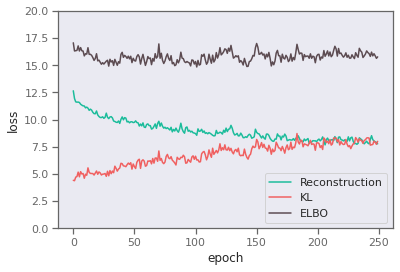

In [53]:
plt.plot([l[0] for l in losses], label='Reconstruction')
plt.plot([l[1] for l in losses], label='KL')
plt.plot([l[1] + l[0] for l in losses], label='ELBO')
plt.legend()
plt.ylim(0, 20)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

As usual, this model is undertrained. A latent space of 2, which we chose for plotting convenience, is also probably a little too compressed. Let's sample a few conformation and see how they look.

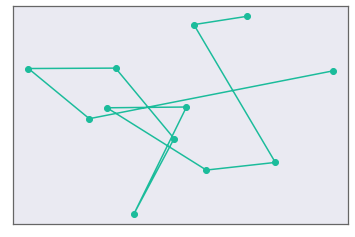

In [54]:
sampled_data = decoder(jax.random.normal(key, shape=[latent_dim]), theta).reshape(-1, 2)
plt.plot(sampled_data[:, 0], sampled_data[:, 1], '-o', alpha=1)
plt.xticks([])
plt.yticks([])
plt.show()

These look reasonable compared with the trajectory video showing the training conformations.

## Using VAE on Trajectory

There are three main things to do with a VAE on a trajectory. The first is to go from a trajectory in the feature dimension to the latent dimension. This can simplify analysis of dynamics or act as a reaction coordinate for free energy methods. The second is to generate new conformations. This could be used to fill-in under sampling or perhaps extrapolate to new regions of latent space. You can also use the VAE to examine marginals that are perhaps under-sampled. Finally, you can do optimization on the latent space. For example, you could try to find the most compact structure. We'll examine these examples but there are many other things you could examine. 

### Latent Trajectory

Let's start by computing a latent trajctory. I'm going to load a shorter trajectory which has the frames closer together in time. 

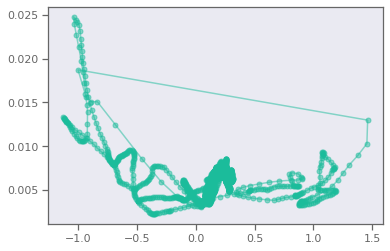

In [55]:
#TODO use github
paths = np.load('../data/paths.npz')['arr']
short_data = align_principle(center_com(paths))

# get latent params 
# throw away standard deviation
latent_traj = batched_encoder(short_data.reshape(-1, input_dim), phi)[:,0]
plt.plot(latent_traj[:,0], latent_traj[:,1], '-o',markersize=5, alpha=0.5)
plt.show()

You can see that the trajectory is relatively continuous, except for a few wide jumps. We'll see below that this is because the alignment process can have big jumps as our principle axis rapidly moves when the points rearrange. Let's compare the video and the z-path side-by-side. You can find the code for this movie on the github repo.

t:   0%|          | 3/2048 [00:00<01:26, 23.52it/s, now=None]

Moviepy - Building video ../_static/images/latent_traj.mp4.
Moviepy - Writing video ../_static/images/latent_traj.mp4



Moviepy - Done !
Moviepy - video ready ../_static/images/latent_traj.mp4


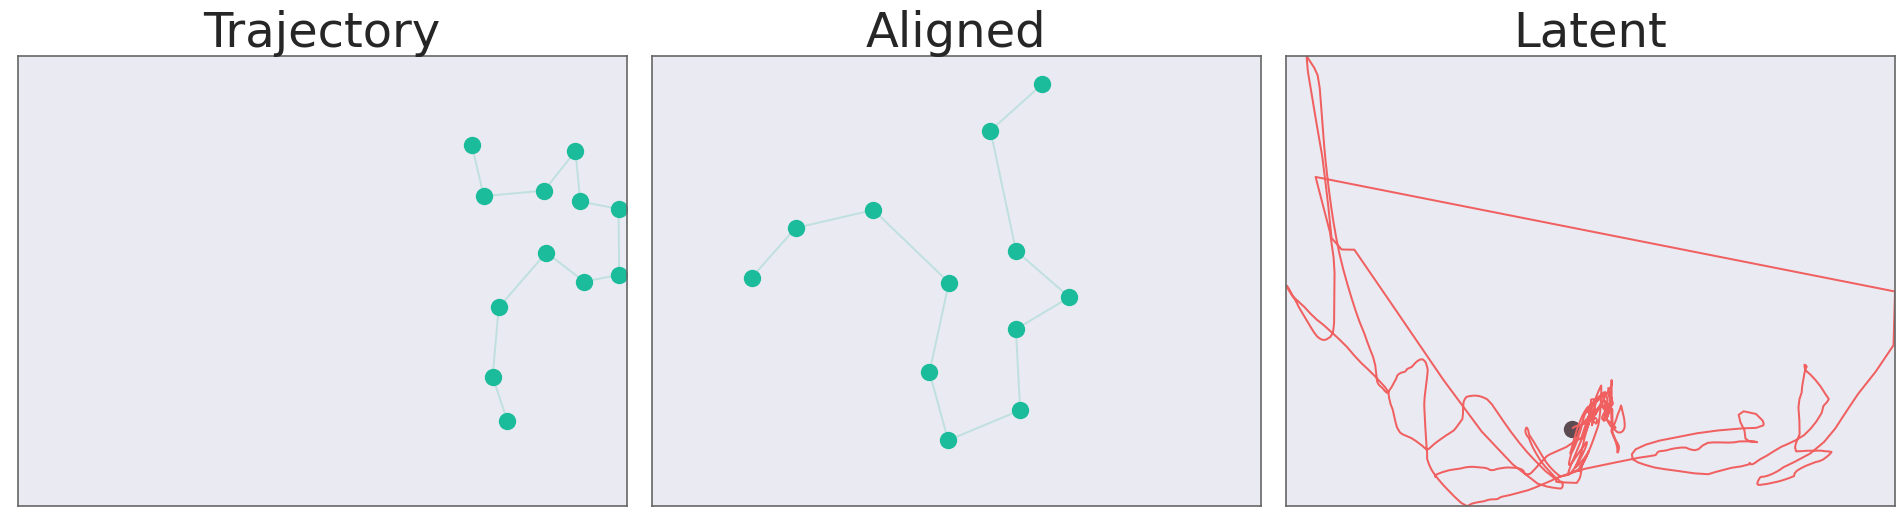

In [69]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.collections import LineCollection


def make_segments(data, time_index):
    points = np.array([data[time_index,:, 0], data[time_index,:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

dpi = 96
fig, axs = plt.subplots(ncols=3, figsize=(1920 / dpi,1080 / dpi / 2), dpi=dpi)
fps = 60
fronts = axs[0].plot(paths[-1][:,0], paths[-1][:,1], 'o', zorder=0, color='C0', markersize=12)[0]
afronts = axs[1].plot(short_data[-1][:,0], short_data[-1][:,1], 'o', zorder=0, color='C0', markersize=12)[0]
zfront = axs[2].plot(latent_traj[0,0], latent_traj[0,1], 'o', zorder=0, color='C2', markersize=12)[0]
zl = axs[2].plot(latent_traj[0,0], latent_traj[1,0], '-', alpha=1, color='C1')[0]
axs[0].set_xlim(np.nanmin(paths, axis=(0,1))[0], np.nanmax(paths, axis=(0,1))[0])
axs[0].set_ylim(np.nanmin(paths, axis=(0,1))[1], np.nanmax(paths, axis=(0,1))[1])
axs[1].set_xlim(np.nanmin(short_data, axis=(0,1))[0], np.nanmax(short_data, axis=(0,1))[0])
axs[1].set_ylim(np.nanmin(short_data, axis=(0,1))[1], np.nanmax(short_data, axis=(0,1))[1])
axs[2].set_xlim(np.min(latent_traj[:,0]), np.max(latent_traj[:,0]))
axs[2].set_ylim(np.min(latent_traj[:,1]), np.max(latent_traj[:,1]))
axs[0].set_title('Trajectory', fontsize=36)
axs[1].set_title('Aligned', fontsize=36)
axs[2].set_title('Latent', fontsize=36)
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()

T = paths.shape[0]
line_collections = []
line_segments = []
aline_segments = []
for i in range(T):
    seg = make_segments(paths, i)
    line_segments.append(seg)
    seg = make_segments(short_data, i)
    aline_segments.append(seg)
    

def make_frame(t):
    frame = int(fps * t)
    if len(line_collections) == 0:
        lc = LineCollection(line_segments[frame], color='C0', norm=plt.Normalize(0,1), alpha=0.2)
        axs[0].add_collection(lc)
        line_collections.append(lc)    
        lc = LineCollection(aline_segments[frame], color='C0', norm=plt.Normalize(0,1), alpha=0.2)
        axs[1].add_collection(lc)
        line_collections.append(lc) 
    j = min(frame, T - 1)
    # Set the values used for colormapping
    #lc.set_array(np.linspace(1,0,T)[:frame])
    line_collections[0].set_segments(line_segments[j]) 
    line_collections[1].set_segments(aline_segments[j]) 
    fronts.set_data(paths[j][:,0], paths[j][:,1])
    afronts.set_data(short_data[j][:,0], short_data[j][:,1])
    zfront.set_data(latent_traj[j,0], latent_traj[j,1])
    zl.set_data(latent_traj[:j,0], latent_traj[:j,1])
    return mplfig_to_npimage(fig)

duration = T / fps
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile(filename='../_static/images/latent_traj.mp4', fps=fps)


<div>
    <video width="500" autoplay loop controls src="../_static/images/latent_traj.mp4" alt="movie of point trajectory"></video>
</div>

You can see the quick change is due to our alignment quickly changing. This is why aligning on the principle axis isn't always perfect: your axis can flip 90 degrees because the internal points change the moment of inertia enough to change. Recall that alternatives are to use PCA across whole trajectory to compute axes or to align to a reference (although that second approach suffers from same issue). 

### Generate New Samples

Let's see how our samples look. 

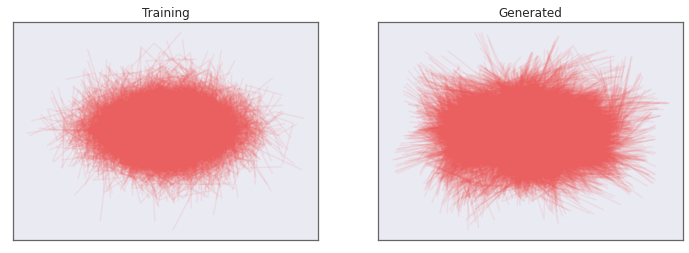

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sampled_data = batched_decoder(
    np.random.normal(size=(data.shape[0], latent_dim)), theta).reshape(data.shape[0],-1, 2)
for i in range(0, data.shape[0]):
    axs[0].plot(data[i, :, 0], data[i, :, 1], '-', alpha=0.1, color='C1')
    axs[1].plot(sampled_data[i, :, 0], sampled_data[i, :, 1], '-', alpha=0.1, color='C1')
axs[0].set_title('Training')
axs[1].set_title('Generated')
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


The samples are not perfect, but we're close. Let's examine the marginals. 

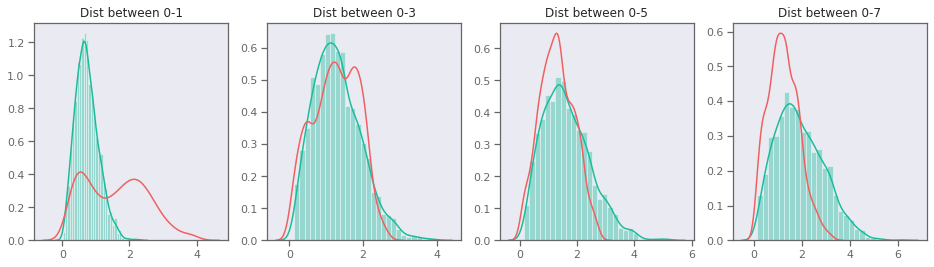

In [60]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i,j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f'Dist between 0-{j}')
    sns.distplot(np.linalg.norm(data[:,0] - data[:,j], axis=1), ax=axs[i])    
    sns.distplot(np.linalg.norm(sampled_data[:,0] - sampled_data[:,j], axis=1), ax=axs[i], hist=False)
    

You can see that there are some issues here as well. Remember that our latent space is quite small: 2D. So we should not be that surprised that we're losing information from our 24D input space. 

### Optimization on Latent Space

Finally, let us examine how we can optimize in the latent space. Let's say I want to find the most compact structure. We'll define our loss function as the radius of gyration for and take its derivative with respect to $z$, instead of the usual weights. Recall the definition of radius of gyration is

\begin{equation}
R_g = \frac{1}{N}\sum_i r_i^2
\end{equation}

where $r_i$ is distance to center of mass. Our generated samples are, by definition, centered at the origin though. 

In [61]:
def rg_loss(z):
    x = decoder(z, theta).reshape(-1, 2)
    rg = jnp.sum(x**2)
    return jnp.sqrt(rg)
rg_grad = jax.jit(jax.grad(rg_loss))

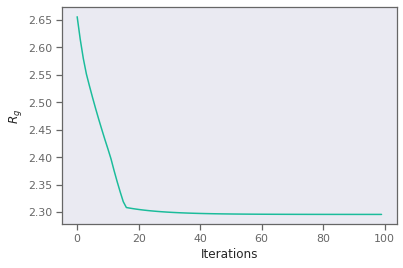

In [67]:
z = jax.random.normal(key, shape=[latent_dim])
losses = []
eta = 1e-2
for i in range(100):
    losses.append(rg_loss(z))    
    g = rg_grad(z)
    z -= eta * g
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('$R_g$')
plt.show()

Now let's compare our optimized structure against what is the lowest one in the training data.

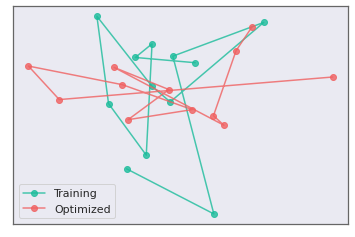

In [68]:
# get min from training
train_rgmin = np.argmin(np.sum(data**2, axis=(1,2)))
# use new z
opt_rgmin = decoder(z, theta).reshape(-1,2)
plt.plot(data[train_rgmin, :, 0], data[train_rgmin,:, 1], 'o-', label='Training', alpha=0.8)
plt.plot(opt_rgmin[:, 0], opt_rgmin[:, 1], 'o-', label='Optimized', alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

What is remarkable about this is that the optimized one has no overlaps and still reasonable bond-lengths. It is also more compact than the lowest radius of gyration found in the training example. 

## Relevant Videos

### Using VAE for Coarse-Grained Molecular Simulation

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/l_NfukhR2XU" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Using VAE for Molecular Graph Generation

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/VXNjCAmb6Zw" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Review of Molecular Graph Generative Models (including VAE)

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/z0lh4kXWt5E" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Cited References

```{bibliography} references.bib
```